In [1]:
import os
import s3fs
import pandas as pd
import torch

In [2]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device utilisé : {device}")

Device utilisé : cuda


In [3]:
S3_ENDPOINT_URL = "https://" + os.environ['AWS_S3_ENDPOINT']

fs = s3fs.S3FileSystem(client_kwargs = {'endpoint_url' : S3_ENDPOINT_URL})

BUCKET = "malcouffe1/Revision"
FILE_KEY_S3 = "/dataset_clean.csv"
FILE_PATH_S3 = BUCKET + FILE_KEY_S3


with fs.open(FILE_PATH_S3, 'rb') as file_in:
    df = pd.read_csv(file_in, sep=',')

In [4]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Conversion en tenseurs PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)

# Chargement dans DataLoader
batch_size = 256
dataset = torch.utils.data.TensorDataset(X_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialisation du modèle
input_dim = X.shape[1]  # Nombre de features
# Initialisation du modèle et envoi sur GPU si disponible
autoencoder = AutoEncoder(input_dim).to(device)



Epoch 1/30, Loss: 0.3899
Epoch 2/30, Loss: 0.1669
Epoch 3/30, Loss: 0.1321
Epoch 4/30, Loss: 0.1013
Epoch 5/30, Loss: 0.0878
Epoch 6/30, Loss: 0.0795
Epoch 7/30, Loss: 0.0734
Epoch 8/30, Loss: 0.0651
Epoch 9/30, Loss: 0.0615
Epoch 10/30, Loss: 0.0564
Epoch 11/30, Loss: 0.0547
Epoch 12/30, Loss: 0.0552
Epoch 13/30, Loss: 0.0511
Epoch 14/30, Loss: 0.0492
Epoch 15/30, Loss: 0.0493
Epoch 16/30, Loss: 0.0463
Epoch 17/30, Loss: 0.0460
Epoch 18/30, Loss: 0.0442
Epoch 19/30, Loss: 0.0433
Epoch 20/30, Loss: 0.0441
Epoch 21/30, Loss: 0.0418
Epoch 22/30, Loss: 0.0413
Epoch 23/30, Loss: 0.0396
Epoch 24/30, Loss: 0.0397
Epoch 25/30, Loss: 0.0378
Epoch 26/30, Loss: 0.0372
Epoch 27/30, Loss: 0.0386
Epoch 28/30, Loss: 0.0358
Epoch 29/30, Loss: 0.0364
Epoch 30/30, Loss: 0.0357


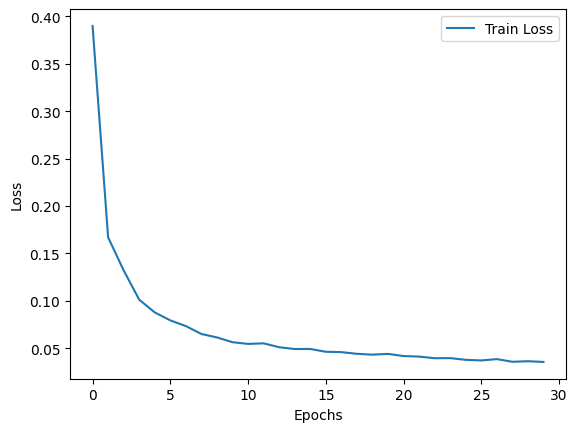

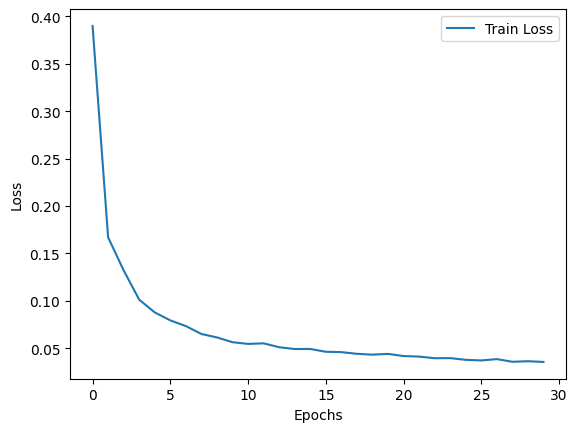

In [7]:
import torch.optim as optim

# Définition de la loss et de l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Entraînement du modèle sur GPU
num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0

    for batch in data_loader:
        inputs = batch[0].to(device)  # Envoi des données sur le GPU
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # Calcul de la MSE
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(data_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}")

# Affichage des résultats
import matplotlib.pyplot as plt
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



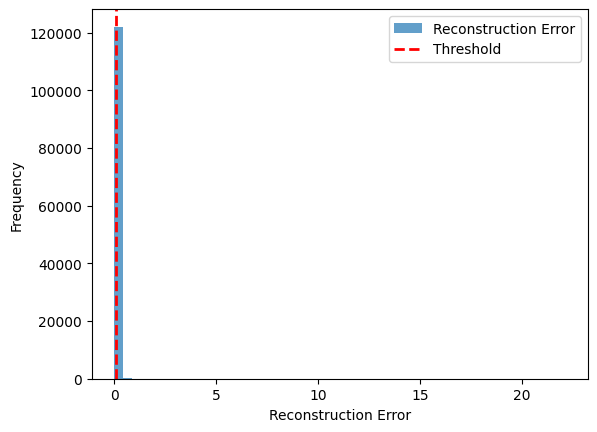

Seuil d'anomalie : 0.1015
Nombre d'anomalies détectées : 6120 sur 122389 observations.


In [8]:
# Calcul des erreurs de reconstruction sur GPU
autoencoder.eval()
reconstruction_errors = []

with torch.no_grad():
    for batch in data_loader:
        inputs = batch[0].to(device)  # Envoi sur GPU
        outputs = autoencoder(inputs)
        loss = torch.mean((inputs - outputs) ** 2, dim=1)  # MSE par observation
        reconstruction_errors.extend(loss.cpu().numpy())  # Retour sur CPU pour analyse

# Définition du seuil d’anomalie (95e percentile)
import numpy as np
threshold = np.percentile(reconstruction_errors, 95)

# Détection des anomalies
anomalies = np.array(reconstruction_errors) > threshold

# Affichage des résultats
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label="Reconstruction Error")
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Seuil d'anomalie : {threshold:.4f}")
print(f"Nombre d'anomalies détectées : {np.sum(anomalies)} sur {len(reconstruction_errors)} observations.")


In [14]:
# Convertir X en numpy si c'est encore un tensor PyTorch
if isinstance(X, torch.Tensor):
    X_numpy = X.cpu().numpy()  # Conversion explicite depuis le GPU
else:
    X_numpy = X  # Sinon, on garde les valeurs originales

# Création du DataFrame Pandas avec les vraies valeurs
df_X = pd.DataFrame(X_numpy, columns=[f'Feature_{i}' for i in range(X_numpy.shape[1])])

# Ajout des erreurs de reconstruction au DataFrame
df_X["Reconstruction_Error"] = reconstruction_errors

# Définition d'une colonne "Anomaly" (1 = anomalie, 0 = normal)
df_X["Anomaly"] = anomalies.astype(int)

# Extraction des lignes anormales
df_anomalies = df_X[df_X["Anomaly"] == 1]

In [15]:
df_anomalies

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,Feature_70,Feature_71,Feature_72,Reconstruction_Error,Anomaly
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117308,1
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511655,1
56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.106141,1
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138014,1
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117853,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394458,1
122325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.150662,1
122330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104305,1
122360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236252,1
